<a href="https://colab.research.google.com/github/matisyo/deepnnfoundations/blob/master/PytorchBasicPhoto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch

In [0]:
import torch.nn.functional as F
from torch import nn
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle,gzip,math,torch,matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

def get_data():
    mnist_url='http://deeplearning.net/data/mnist/mnist.pkl'
    path = datasets.download_data(mnist_url,ext='.gz')
    with gzip.open(path,'rb') as f:
        ((x_train, y_train), (x_valid,y_valid), _) = pickle.load(f,encoding='latin-1')
    return map(tensor,(x_train,y_train,x_valid,y_valid))
def normalize(x,m,s):
    return (x-m)/s
mpl.rcParams['image.cmap'] = 'summer'

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

In [0]:
def normalize_to(train,valid):
  m,s = train.mean(),train.std()
  return normalize(train,m,s),normalize(valid,m,s)

In [0]:
x_train,x_valid = normalize_to(x_train,x_valid)

In [0]:
class Lambda(nn.Module):
    def __init__(self,func):
        super().__init__()
        self.func = func
    def forward(self,x):
        return self.func(x)

def flatten(x):
    return x.view(x.shape[0],-1)

def mnist_resize(x):
    return x.view(-1,1,28,28)

In [0]:

def create_model():
  model = nn.Sequential(
    Lambda(mnist_resize),
    nn.Sequential(nn.Conv2d(1,8,5,padding=2,stride=2),nn.ReLU()),
    nn.Sequential(nn.Conv2d(8,16,3,padding=1,stride=2),nn.ReLU()),
    nn.Sequential(nn.Conv2d(16,32,3,padding=1,stride=2),nn.ReLU()),
    nn.Sequential(nn.Conv2d(32,32,3,padding=1,stride=2),nn.ReLU()),      
    nn.AdaptiveAvgPool2d(1),
    Lambda(flatten),
    nn.Linear(32,10)  
  )
  return model



In [0]:
def init_kai(model):    
  for l in model:
    if isinstance(l, nn.Sequential):      
      nn.init.kaiming_normal_(l[0].weight)
      l[0].bias.data.zero_()

In [0]:
from functools import partial

means = []
stds = []
def append_stats(i,mod,inp,out):
  means[i] = out.data.mean().cpu()
  stds[i] = out.data.std().cpu()  
  
def get_stats(model,xb):
  hks = []
  for i,m in enumerate(model):  
    means.append([])
    stds.append([])
      
    if isinstance(m, nn.Sequential):   
      t = m.register_forward_hook(partial(append_stats,i))      
      hks.append(t)
  
  model(xb)
  print([ls for ls in means if type(ls) != list])
  print([ls for ls in stds if type(ls) != list])
   
  for h in hks:    
    h.remove()

In [0]:
from functools import partial

data = [0,0]
def lsuv_tmp(mod,inp,out):
  data[0] = out.data.mean().cpu()
  data[1] = out.data.std().cpu()  
  
def init_lsuv(model,xb):
  
  hks = []
  for i,m in enumerate(model):  
      
    if isinstance(m, nn.Sequential):   
      h = m.register_forward_hook(lsuv_tmp)
      
      while True:
        model(xb)
        m[0].bias.data -= data[0]
        if abs(data[0]) <= 1e-3:
          break
          
      while True:
        model(xb)
        m[0].weight.data /= data[1]
        if abs(data[1]-1) <= 1e-3:
          break
          
      h.remove()

In [119]:
model = create_model()
get_stats(model.cuda(),x_train[:128,:].cuda())

[tensor(0.2241), tensor(0.1331), tensor(0.0493), tensor(0.0263)]
[tensor(0.4179), tensor(0.2026), tensor(0.0782), tensor(0.0339)]


In [120]:
model = create_model()
init_kai(model)
get_stats(model.cuda(),x_train[:128,:].cuda())

[tensor(0.4853), tensor(0.3633), tensor(0.3910), tensor(0.3498)]
[tensor(1.0795), tensor(0.8469), tensor(0.7430), tensor(0.6519)]


In [140]:
model = create_model()
init_lsuv(model.cuda(),x_train[:128,:].cuda())
get_stats(model.cuda(),x_train[:128,:].cuda())

[tensor(0.2106), tensor(0.2021), tensor(0.2234), tensor(0.2084)]
[tensor(0.9995), tensor(0.9995), tensor(0.9996), tensor(1.0002)]


In [0]:
mods = [ x for x in model if isinstance(x, nn.Sequential)]

In [0]:
from functools import partial
act_means = []
act_stds = []
act_hists = []

def append_hist(i,mod,inp,out):
  act_means[i].append(out.data.mean().cpu())
  act_stds[i].append(out.data.std().cpu())
  act_hists[i].append(out.data.cpu().histc(40,0,10))
  
for i,m in enumerate(mods):  
  act_means.append([])
  act_stds.append([])
  act_hists.append([])
  m.register_forward_hook(partial(append_hist,i))

In [146]:
x_train.shape

torch.Size([50000, 784])

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_f = F.cross_entropy
bs = 128

In [0]:
device = torch.device('cuda',0)
torch.cuda.set_device(device)

In [0]:
def fit(epochs,model):  
  model.cuda()
  for epoch in range(epochs):
      for i in range(0,x_train.shape[0],bs):
          xb = x_train[i:i+bs].cuda()          
          preds = model(xb)

          yb = y_train[i:i+bs].cuda()         

          loss = loss_f(preds,yb)

          loss.backward()

          opt.step()
          opt.zero_grad()   
      with torch.no_grad():
          numerador,denominador = 0.0,0.0
          for i in range(0,x_valid.shape[0],bs):
              xb = x_valid[i:i+bs].cuda()              
              preds = model(xb)
              yb = y_valid[i:i+bs].cuda()

              numerador += (preds.argmax(dim=1)==yb).sum()
              denominador += yb.shape[0]
          print("Epoch: {}  Accuracy : {}".format(epoch,float(numerador)/float(denominador)))
              #loss = loss_f(preds,yb)
              #loss.backward()
              #opt.step()
              #opt.zero_grad()   


In [0]:
act_means = [[] for i in range(8)]
act_stds = [[] for i in range(8)]
act_hists = [[] for i in range(8)]

In [151]:
%time fit(2,model)

Epoch: 0  Accuracy : 0.6591
Epoch: 1  Accuracy : 0.8363
CPU times: user 9.55 s, sys: 1.54 s, total: 11.1 s
Wall time: 11.1 s


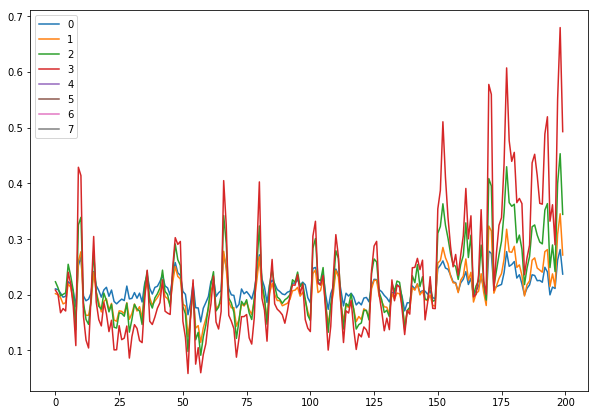

In [152]:
fig = plt.figure(figsize=(10,7))
for l in act_means:
  plt.plot(l[:200])
plt.legend(range(8))
    

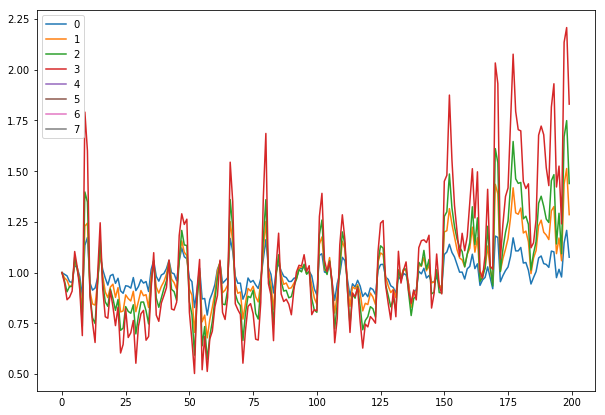

In [153]:
fig = plt.figure(figsize=(10,7))
for l in act_stds:
  plt.plot(l[:200])
plt.legend(range(8))

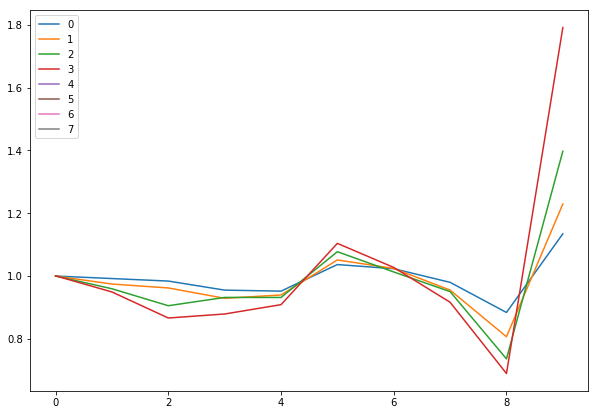

In [154]:
fig = plt.figure(figsize=(10,7))
for l in act_stds:
  plt.plot(l[:10])
plt.legend(range(8))

In [0]:
def get_hist(i):
  return torch.stack(act_hists[i][:200]).t().float().log1p()
def get_min(i):
  t = torch.stack(act_hists[i][:200]).t().float().log1p()
  return t[:2].sum(0)/t.sum(0)

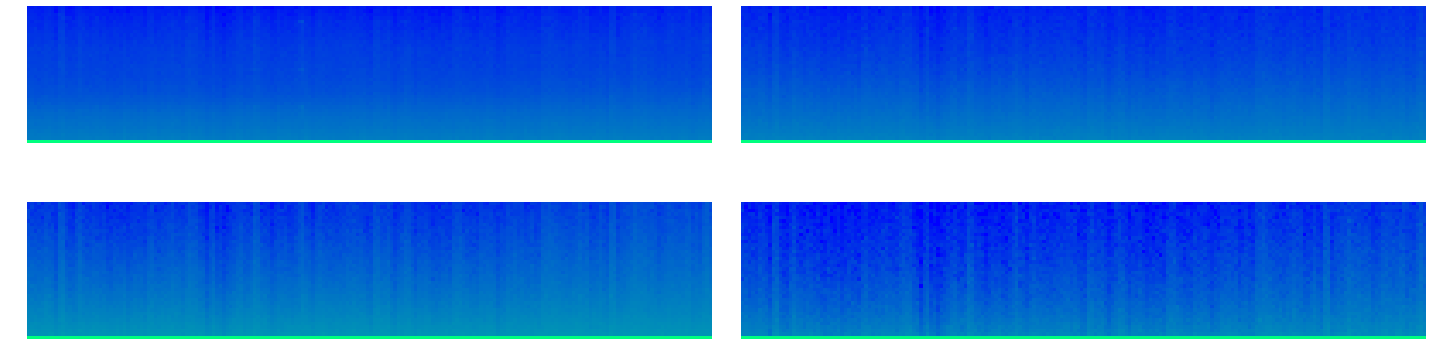

In [157]:
mpl.rcParams['image.cmap'] = 'winter'
fig,axes = plt.subplots(2,2, figsize = (20,6))
for i,ax in enumerate(axes.flatten()):    
  ax.imshow(get_hist(i),origin='lower')
  ax.axis('off')
plt.tight_layout()

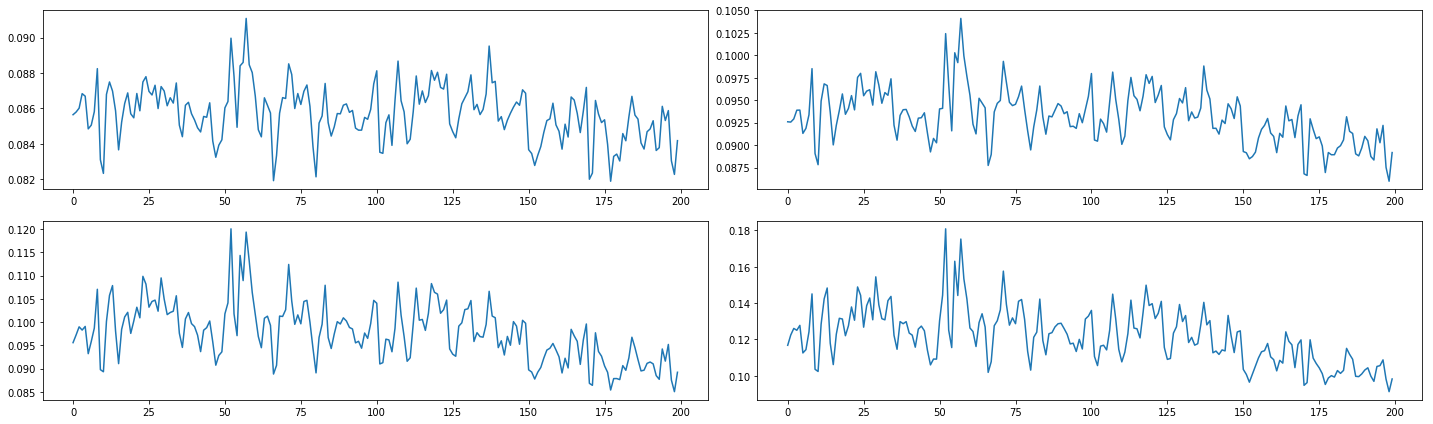

In [178]:

fig,axes = plt.subplots(2,2, figsize = (20,6))
for i,ax in enumerate(axes.flatten()):    
  t = get_min(i).view(-1).numpy()
  ax.plot(t)
  
plt.tight_layout()
